In [53]:
import matplotlib
%matplotlib inline 
# matplotlib.use('agg')
# coding: utf-8

import csv
import poppy
# get_ipython().run_line_magic('pylab', 'inline --no-import-all')
# matplotlib.rcParams['image.origin'] = 'lower'
print(poppy.__version__)

from poppy.sub_sampled_optics import subapertures, SH_WFS
from poppy.poppy_core import PlaneType
from matplotlib.colors import LogNorm
import poppy.fwcentroid as fwcentroid
from matplotlib import pyplot as plt

import logging
import astropy.units as u
import copy
import numpy as np
logging.getLogger('poppy').setLevel(logging.INFO)  
#Can be logging.CRITICAL, logging.WARN, logging.INFO, logging.DEBUG for increasingly verbose output


0.9.0


INFO:poppy:Computing opd for DM sampled onto 512 pixel grid with pixelscale 2.9296875 um / pix


n lenslets 10
68
122.64393884962487 83397.87841774491


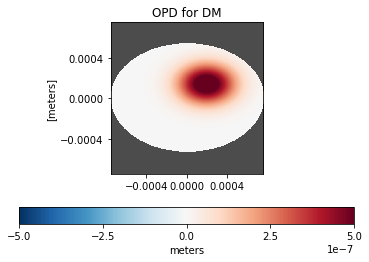

In [96]:
## define parameters: 
wavelength = .635e-6 #red
pixel_pitch = 2.2*u.um #both detectors have same pixel pitch 
lenslet_pitch = 150*u.um
dm_size = lenslet_pitch*10
n_lenslets=int((dm_size.to(u.m)/lenslet_pitch.to(u.m)).value)
print("n lenslets", n_lenslets)
r_lenslet = lenslet_pitch/2.
lenslet_focal_length = .0037*u.m
pix_per_lenslet = int(lenslet_pitch/pixel_pitch)
print(pix_per_lenslet)

plate_scale = 1.0*u.rad/(lenslet_focal_length.to(u.m)) 
rad_pix = (plate_scale*pixel_pitch.to(u.m))/u.pix #radians per pixel
plate_scale_converted = rad_pix.to(u.arcsec/u.pix).value #arcsec per pixel
print(plate_scale_converted, plate_scale_converted*pix_per_lenslet*n_lenslets)

## define DM
act_x = 2
act_y = 2
stroke = .3e-6
dm_actuator_pitch = dm_size/4 #450*u.um from BMC Multi-DM user manual 
dm = poppy.dms.ContinuousDeformableMirror(dm_shape=(4,4), 
    actuator_spacing=dm_actuator_pitch, radius=dm_size/2, 
    inclination_x =45)
dm.set_actuator(act_x, act_y, 2*stroke)
 #note *2 to account for reflection off of DM (OPD is 2* surface shape)
shwfs_detector = poppy.Detector(plate_scale_converted,
               fov_pixels=pix_per_lenslet)

dm.display()

wf_flat = poppy.Wavefront(diam=dm_size, wavelength=wavelength, npix=68*n_lenslets)
wf_flat *= poppy.CircularAperture(radius = dm_size/2)

wf = poppy.Wavefront(diam=dm_size, wavelength=wavelength, npix=68*n_lenslets)
wf *= poppy.CircularAperture(radius = dm_size/2)
wf *= dm 


In [97]:
print(n_lenslets)
shwfs = SH_WFS(lenslet_pitch= lenslet_pitch, 
               lenslet_fl=lenslet_focal_length, 
               pixel_pitch=pixel_pitch, 
               n_lenslets = n_lenslets, 
               circular = True, detector = shwfs_detector)


10


In [98]:
#get flat centroids for wf reconstruction:
shwfs.sample_wf(wf_flat)
shwfs.get_psfs()
flat_centroid_list = shwfs.get_centroids()

#sample wf and propagate to detector: 
shwfs.sample_wf(wf)
shwfs.get_psfs()


Tiling propagated wavefront arrays.


Text(0.5, 1.0, 'Single Lenslet PSF')

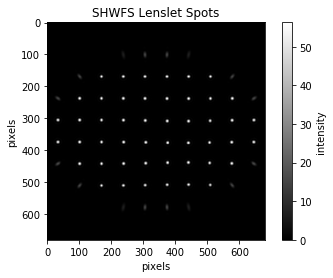

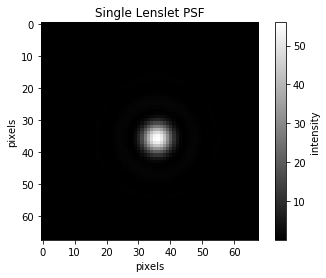

In [99]:
# retrieve and display wavefront array:
wf_array = shwfs.get_wavefront_array()
plt.figure()
plt.imshow(wf_array.intensity, cmap = 'gray')
plt.colorbar(label = 'intensity')
plt.xlabel('pixels')
plt.ylabel('pixels')
plt.title("SHWFS Lenslet Spots")

# display single psf: 
single_psf = shwfs.wf_array[5,5]
plt.figure()
plt.imshow(single_psf.intensity, cmap = 'gray')
plt.colorbar(label = 'intensity')
plt.xlabel('pixels')
plt.ylabel('pixels')
plt.title("Single Lenslet PSF")

In [100]:
#reconstruct wavefront:
reconstruction = shwfs.reconstruct_wavefront(flat_centroid_list)


Algorithm terminated at max iterations without convergence.


Algorithm terminated at max iterations without convergence.


Algorithm terminated at max iterations without convergence.


Algorithm terminated at max iterations without convergence.


Text(0.5, 1.0, 'Reconstructed Wavefront')

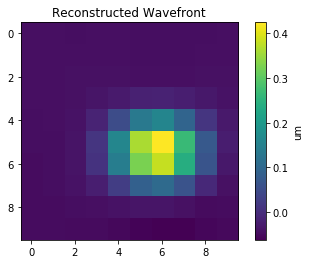

In [101]:
#display result:
plt.figure()
plt.imshow(reconstruction.value)
plt.colorbar(label = 'um')
plt.title("Reconstructed Wavefront")

#note: with the small number of spots across the DM 